<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.2.%20CNN%20con%20datasets%20peque%C3%B1os.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 5.2. REDES CONVOLUCIONALES CON REGULARIZACIÓN

Es común oir que Deep Learning solo es válido cuando tenemos una cantidad inmensa de datos, y aunque es una afirmación que es válida parcialmente (ya que extrae características interesantes de los datos sin necesidad de acudir a ingeniería manual), podemos encontrar situaciones en las que con unos cientos de datos es suficiente para extraer un modelo (pequeño) interesante si el problema presenta suficiente regularidad.

In [191]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 1. Introducción

Tener que entrenar un modelo de clasificación sobre pocos datos es una situación muy común. Aunque, por supuesto, qué consideramos pocos datos es algo que depende del problema y del contexto, y puede ir desde unos cuantos cientos hasta decenas de miles cuando el problema es más complicado.

Para trabajar en un caso como éste, vamos a construir un pequeño clasificador de imágenes para distinguir entre "perros" y "gatos". El dataset que usaremos está extraído de una competición de Kaggle en el que los datos los proporciona [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765). El dataset original contiene 25.000 imágenes, pero nosotros usaremos solo una sección con un total de 4.000 imágenes (2.000 de cada tipo), teniendo 2.000 / 1.000 / 1.000 de entrenamiento / validación / test, respectivamente, completamente balanceados.

Vamos a comenzar con una versión muy sencilla de una red convolucional que entrenaremos con las 2.000 imágenes que tenemos en el conjunto de entrenamiento, sin hacer ningún tipo de regularización, solo con el fin de obtener un modelo base sobre el que medir posteriormente las mejoras que introduzcamos. Con esta primera versión, sin ningún tipo de mejora adicional, seremos capaces de alcanzar ~70% de accuracy. Veremos que en este momento nuestro principal problema es el de sobreajuste, debido principalmente a la ausencia de suficientes datos para entrenar, por lo que tendremos que introducir alguna técnica que nos permita aliviar este problema. 

En el módulo de Regularización dejamos pendiente el uso de la técnica de **Data Augmentation**, que haremos uso aquí ya que estamos trabajando con imágenes. También usaremos dropout y batch normalization que permitirá alcanzar un rendimiento que rondará el 82% (una mejora del 12% absoluto).

## 2. El Dataset

### 2.1. Descarga del dataset

Para reproducir esta práctica, primero debes descargar y descompirmir el dataset reducido con la siguiente celda, si estás en un entorno Linux. Si estás en Windows, pincha en el siguiente [enlace](https://uses0-my.sharepoint.com/:u:/g/personal/mdelamor_us_es/EeHAFo1ac-VIlvqZqn5sp98BspJ3kCj5hapABdroe-kkuw?e=s2gM5U) y descomprime el .zip. 

In [14]:
%%bash

if [ ! -d "data/cat_dogs" ]; then
    wget https://uses0-my.sharepoint.com/:u:/g/personal/mdelamor_us_es/EeHAFo1ac-VIlvqZqn5sp98BspJ3kCj5hapABdroe-kkuw?download=1 -O data/cat_dogs.zip

    if [ ! -f "data/cat_dogs.zip" ]; then
        echo "Error de descarga. Revisa el fichero"
    else
        unzip -q data/cat_dogs.zip -d data/ 
    fi
        
    echo "¡Dataset descargado!"
else
    # Comandos a ejecutar si SÍ existe
    echo "El dataset ya existe"
fi

El dataset ya existe


En la carpeta `cat_dogs` puedes encontrar el conjunto inicial de 4.000 imágenes. Dentro de esa carpeta ya están separadas las imágenes en los diversos conjuntos de entrenamiento, validación y test que usaremos, así como las carpetas `cats` y `dogs` con las imágenes originales.

Puedes comprobar que los números que indicábamos son los correctos:


In [15]:
train_cats_dir = 'data/cat_dogs/train/cats'
print('Número imágenes entrenamiento Gatos:', len(os.listdir(train_cats_dir)))

Número imágenes entrenamiento Gatos: 999


In [16]:
train_dogs_dir = 'data/cat_dogs/train/dogs'
print('Número imágenes entrenamiento Perros:', len(os.listdir(train_dogs_dir)))

Número imágenes entrenamiento Perros: 1000


In [20]:
validation_cats_dir = 'data/cat_dogs/validation/cats'
print('Número imágenes validación Gatos:', len(os.listdir(validation_cats_dir)))

Número imágenes validación Gatos: 500


In [21]:
validation_dogs_dir = 'data/cat_dogs/validation/dogs'
print('Número imágenes validación Perros:', len(os.listdir(validation_dogs_dir)))

Número imágenes validación Perros: 500


In [22]:
test_cats_dir = 'data/cat_dogs/test/cats'
print('Número imágenes test Gatos:', len(os.listdir(test_cats_dir)))

Número imágenes test Gatos: 500


In [23]:
test_dogs_dir = 'data/cat_dogs/test/dogs'
print('Número imágenes test Perros:', len(os.listdir(test_dogs_dir)))

Número imágenes test Perros: 500



Como el conjunto está completamente balanceado, la precisión de clasificación (binaria, en este caso) es una buena medida del rendimiento del modelo. 

### 2.2 Preprocesamiento de los Datos

Como ya sabemos, los datos deben ser formateados para ser convertidos en tensores de punto flotante para alimentar la red, pero lo que tenemos son ficheros JPEG, así que los pasos para convertirlos son:

* Leer los ficheros de imágenes.
* Decodificar JPEG en una matriz de RGB.
* Convertir la matriz en tensores de punto flotante.
* Re-escalar los valores de `[0,255]` a `[0, 1]`.

Aunque puede parece algo tedioso, PyTorch proporciona utilidades para llevar a cabo este tipo de acciones, que son muy comunes. En particular, incluye la clase dataset [`ImageFolder`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) que ya se encarga de leer ficheros JPG de una carpeta. Este tipo de dataset asume que hay una subcarpeta por clase (como es ya nuestro caso). La transformación `.Resize` cambiará el tamaño de las imágenes a un tamaño fijo, cosa que será útil a la hora de entrenar la red (como veremos), mientras que la transformación `.ToTensor()` convierte los datos a un tensor en punto flotante y los normaliza entre 0 y 1.

In [ ]:
# Configuramos la ruta a los datos de train y validación
data_dir = './data/cat_dogs'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')

input_size = 150

# Definimos las transformaciones
transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor()
])

# Crearemos datasets a partir de carpetas. 
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms)

print('Clases:', train_dataset.classes)
print('Tamaños train/val:', len(train_dataset), len(val_dataset))

batch_size = 32

# Definimos los cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Clases: ['cats', 'dogs']
Tamaños train/val: 1999 1000


**Ejercicio:** Define el dataset y el dataloader para el conjunto de test.

In [25]:
# Solución
test_dir = os.path.join(data_dir, 'test')
test_dataset = datasets.ImageFolder(test_dir, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Este proceso ha generado un paquete (batch) de imágenes de tamaño `(32, 3, 150, 150)` (32 imágenes de 150x150 con 3 canales) y un paquete (batch) de etiquetas de tamaño `(32)`.

In [ ]:
for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)    
    break

data batch shape: torch.Size([32, 3, 150, 150])
labels batch shape: torch.Size([32])
labels batch shape: torch.int64


## 3. Construyendo el modelo

Vamos a reutilizar la estructura de Red Convolucional que vimos en el ejemplo anterior (MNIST), que constaba de una pila alternada de capas `Conv2d()` (con activación `ReLU`) y capas `MaxPool2d()`. 

Como las imágenes de este problema son más grandes y el problema es más complejo, haremos la red más grande con una capa más de cada tipo, por lo que aumentaremos la capacidad de la red y a la vez reduciremos el tamaño de salida de la última capa, que habrá que aplanar de forma similar con `Flatten()`. Como comenzamos con imágenes de tamaño 150x150 (es arbitrario), acabaremos con un mapa de características de 7x7 justo como entrada a la capa `Flatten()`.

A medida que la profundidad del mapa de características aumente (de 32 a 128), el tamaño del mismo disminuye (de 148x148 a 7x7), un patrón que es habitual en la mayoría de redes CNN.

Como el problema es de clasificación binaria, acabamos la red con una capa `Linear()` de una sola unidad, que codificará la probabilidad de que la red esté mirando un elemento de cada una de las clases.

**Ejercicio**: Vamos a diseñar una red con 4 bloques convolucionales con 32, 64, 128 y 128 neuronas cada uno, donde cada bloque consta de una capa convolucional, la función ReLU y un Max Pooling. Reemplaza los FIXME a continuación:


In [ ]:
layers = [
    # La entrada es (3 canales de color, 150, 150)
    # Bloque 1: conv 32 unidades
    nn.Conv2d(FIXME=FIXME, FIXME=FIXME, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.FIXME(kernel_size=(2, 2)),  # Max pooling

    # Bloque 2: conv 64 unidades
    nn.Conv2d(FIXME=FIXME, FIXME=FIXME, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3: conv 128 unidades
    nn.Conv2d(FIXME=FIXME, FIXME=FIXME, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 4: conv 128 unidades
    nn.Conv2d(FIXME=FIXME, FIXME=FIXME, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 5: Flatten()
    nn.Flatten(),
    
    # Bloque 6: Fully Connected 512
    nn.Linear(in_features=128 * FIXME * FIXME, out_features=512),
    nn.ReLU(),
    
    # Bloque 7: Fully Coonected 1 (clasificación binaria)
    nn.Linear(in_features=512, out_features=1)
]

CNN = nn.Sequential(*layers)

CNN = CNN.to(device)

CNN_C = torch.compile(CNN)

In [ ]:
# Solución
layers = [
    # La entrada es (3 canales de color, 150, 150)
    # Bloque 1: conv 32 unidades
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 2: conv 64 unidades
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3: conv 128 unidades
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 4: conv 128 unidades
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 5: Flatten()
    nn.Flatten(),
    
    # Bloque 6: Fully Connected 512
    nn.Linear(in_features=128 * 7 * 7, out_features=512),
    nn.ReLU(),
    
    # Bloque 7: Fully Coonected 1 (clasificación binaria)
    nn.Linear(in_features=512, out_features=1)
]

CNN = nn.Sequential(*layers)

CNN = CNN.to(device)

CNNc = torch.compile(CNN)

Mira la arquitectura construida:
<!--![](imgs/CNNCatsDogs_plot.png)-->

In [ ]:
from torchsummary import summary

summary(CNNc,(3,input_size,input_size),verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 148, 148]        896
|    └─ReLU: 2-2                         [-1, 32, 148, 148]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 74, 74]          --
|    └─Conv2d: 2-4                       [-1, 64, 72, 72]          18,496
|    └─ReLU: 2-5                         [-1, 64, 72, 72]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 36, 36]          --
|    └─Conv2d: 2-7                       [-1, 128, 34, 34]         73,856
|    └─ReLU: 2-8                         [-1, 128, 34, 34]         --
|    └─MaxPool2d: 2-9                    [-1, 128, 17, 17]         --
|    └─Conv2d: 2-10                      [-1, 128, 15, 15]         147,584
|    └─ReLU: 2-11                        [-1, 128, 15, 15]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 7, 7]           --
|

Definimos la función de pérdida para clasificación binaria, y el optimizador RMSprop

In [ ]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.RMSprop(CNNc.parameters(), lr=1e-4)

Ahora podemos definir la función para entrenar el modelo. Vamos a usar la misma que en la práctica 3.3, pero separando la parte de evaluación de la de entrenamiento, y haciendo uso de la GPU. Es por ello que resaltaremos los cambios para que puedas ir más rápido a la hora de ver el código:


In [94]:
def binary_accuracy(logits, y, threshold = 0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold)
    correct = (preds == y)
    return correct.sum().item() / correct.shape[0]

def evaluate(model, loader, loss_fn):
    model.eval() 
    loss_acum, accu_acum = 0, 0
    with torch.no_grad(): 
        for x, y in loader:
            # Enviamos los datos la GPU. Y aprovechamos para convertir
            # la etiqueta a float (por defecto, ImageFolder devuelve int64 para las labels)
            x, y = x.to(device), y.float().to(device) # <-- Enviamos datos a la GPU
            preds = model(x).squeeze()
            loss = loss_fn(preds, y)
            loss_acum += loss.item()
            accu_acum += binary_accuracy(preds,y)
    avg_val_loss = loss_acum / len(loader)        
    avg_val_accu = accu_acum / len(loader)   
    return avg_val_loss, avg_val_accu

def train_model(model, epochs, train_loader, valid_loader, loss_fn, optimizer):  
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} 
    # --- Bucle principal ---
    for epoch in range(epochs):
        # --- Fase de Entrenamiento ---
        model.train() 
        loss_acum, accu_acum = 0, 0            
        for x, y in train_loader:
            # Enviamos los datos la GPU. Y aprovechamos para convertir
            # la etiqueta a float (por defecto, ImageFolder devuelve int64 para las labels)
            x, y = x.to(device), y.float().to(device) # <-- Enviamos datos a la GPU
            optimizer.zero_grad()
            preds = model(x)
            preds = preds.squeeze()  
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            # calculamos métricas
            loss_acum += loss.item()
            accu_acum += binary_accuracy(preds,y)                          
    
        avg_train_loss = loss_acum / len(train_loader)        
        avg_train_accu = accu_acum / len(train_loader)

        # --- Fase de Validación ---
        avg_val_loss, avg_val_accu = evaluate(model,val_loader,loss_fn)        
        
        print(f"Epoch [{epoch:02d}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {avg_train_accu:.4f}, Validation Accuracy: {avg_val_accu:.4f}")

        history['train_loss'].append(avg_train_loss), history['val_loss'].append(avg_val_loss), history['train_acc'].append(avg_train_accu), history['val_acc'].append(avg_val_accu)
    return history
    print("\n--- Entrenamiento finalizado ---")

In [ ]:
%%time 
epochs = 30
history = train_model(CNNc, epochs, train_loader, val_loader, criterion, optimizer)

Epoch [00/30], Train Loss: 0.6944, Validation Loss: 0.6902, Train Accuracy: 0.5095, Validation Accuracy: 0.5186
Epoch [01/30], Train Loss: 0.6900, Validation Loss: 0.6828, Train Accuracy: 0.5447, Validation Accuracy: 0.5156
Epoch [02/30], Train Loss: 0.6763, Validation Loss: 0.6527, Train Accuracy: 0.5736, Validation Accuracy: 0.6406
Epoch [03/30], Train Loss: 0.6575, Validation Loss: 0.6378, Train Accuracy: 0.6085, Validation Accuracy: 0.6484
Epoch [04/30], Train Loss: 0.6391, Validation Loss: 0.6238, Train Accuracy: 0.6349, Validation Accuracy: 0.6543
Epoch [05/30], Train Loss: 0.6167, Validation Loss: 0.6541, Train Accuracy: 0.6685, Validation Accuracy: 0.6016
Epoch [06/30], Train Loss: 0.5974, Validation Loss: 0.6316, Train Accuracy: 0.6804, Validation Accuracy: 0.6260
Epoch [07/30], Train Loss: 0.5822, Validation Loss: 0.6198, Train Accuracy: 0.6970, Validation Accuracy: 0.6592
Epoch [08/30], Train Loss: 0.5794, Validation Loss: 0.6058, Train Accuracy: 0.7046, Validation Accuracy:

Representemos la pérdida y precisión experimentada en el proceso de entrenamiento para poder analizar cómo se comporta el modelo:


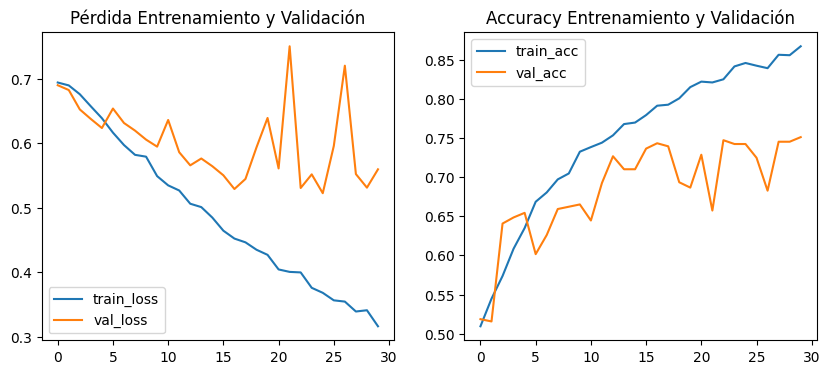

In [150]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Pérdida Entrenamiento y Validación')

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend()
    plt.title('Accuracy Entrenamiento y Validación')
    plt.show()

plot_history(history)

Según vimos en el tema anterior, estas curvas son características de un aprendizaje con sobreajuste: la precisión de entrenamiento se incrementa linealmente con el tiempo, hasta alcanzar valores cercanos al 100%, mientras que la de validación se estanca en el 70-75%. La pérdida de validación alcanza el mínimo tras unas 5 epochs, mientras que la de entrenamiento continúa cayendo hasta que prácticamente alcanza el valor 0.

Como tenemos relativamente pocos ejemplos de entrenamiento, el sobreajuste se convierte en nuestro principal problema. Ya hemos visto algunas técnicas para mitigar este efecto, como son dropout y regularization, pero en esta ocasión comprobaremos cómo funciona **Data Augmentation**, que suele dar buenos resultados al trabajar con imágenes.

## 4. Usando Data Augmentation

Con una cantidad inifinita de datos, mostrando todas las posibles opciones existentes, el modelo nunca se sobreajustaría. _Data augmentation_ intenta simular esta situación ideal generando más datos de entrenamiento a partir de los ejemplos disponibles por medio de la aplicación de transformaciones aleatorias que generan imágenes similares. El objetivo es hacer que nuestro modelo no vea dos veces la misma imagen exacta, lo que ayuda a que el modelo generalice mejor.

En PyTorch esto se puede hacer configurando un conjunto de transformaciones para que sean ejecutadas sobre las imágenes de cada batch leído. A continuación veremos algunos ejemplos de los disponibles dentro de [`transforms`](https://docs.pytorch.org/vision/main/transforms.html#transforms):
* `ToPILImage`: convierte el tensor de vuelta a una imagen (no realiza una transformación a la imagen en sí).
* `RandomResizedCrop`: primero hace un zoom sobre la imagen y después recorta el sobrante, dejando la nueva imagen con el tamaño y el aspect ratio que se le indique.
* `RandomHorizontalFlip`: hace un volteado horizontal de la imagen. Existe también la variante para vertical, sin embargo hay que tener bien claro si tiene sentido, en nuestro caso, ver un gato boca abajo. Para este ejemplo, por tanto, solo aplicaremos volteado horizontal.
* `RandomRotation`: aplica una rotación de la imagen hasta un cierto grado de inclinación. La rotación se puede realizar con el ángulo en negativo como en positivo.
* `ColorJitter`: modifica los colores de la imagen pudiendo tocar los siguientes argumentos: `brightness` (brillo), `contrast` (contraste), `saturation` (saturación), `hue` (tono).

Existen muchísimas más opciones que podrás ver en la documentación, pero por el momento nos quedamos con estas opciones. Vamos a visualizar cómo afectan a un ejemplo del conjunto de entrenamiento. Evalúa la siguiente celda varias veces para ver cómo puede cambiar el resultado, puesto que las transformaciones se aplican con aleatoriedad.

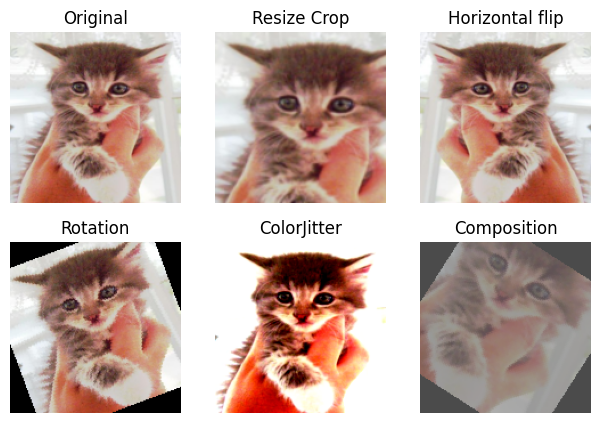

In [193]:
# Elige una imagen del dataset, por ejemplo:
img_example, _ = train_dataset[3]

plt.figure(figsize=(7.5, 5))

# Imagen original
trans = transforms.Compose([v2.ToPILImage()])
image = trans(img_example)

# Imagen transformada con RandomResizedCrop
trans = transforms.Compose([
    transforms.RandomResizedCrop((150, 150), scale=(.2, 1), ratio=(1, 1)),
    v2.ToPILImage()
])
imageRC = trans(img_example)

# Imagen transformada con RandomHorizontalFlip
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    v2.ToPILImage()
])
imageH = trans(img_example)

# Imagen transformada con RandomRotation
trans = transforms.Compose([
    transforms.RandomRotation(45),
    v2.ToPILImage()
])
imageR = trans(img_example)

# Imagen transformada con ColorJitter
trans = transforms.Compose([
    transforms.ColorJitter(brightness=.2, contrast=.7),
    v2.ToPILImage()
])
imageCJ = trans(img_example)

# Imagen transformada con la combinacion de las anteriores
trans = transforms.Compose([
    transforms.RandomResizedCrop((150, 150), scale=(.2, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=.2, contrast=.7),
    v2.ToPILImage()
])
imageC = trans(img_example)

# Visualizamos las 6 imágenes
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(imageRC)
plt.title("Resize Crop")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(imageH)
plt.title("Horizontal flip")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(imageR)
plt.title("Rotation")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(imageCJ)
plt.title("ColorJitter")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(imageC)
plt.title("Composition")
plt.axis('off')


plt.show()

Si entrenamos una red usando esta nueva configuración con datos aumentados, ésta no verá dos veces la misma entrada, aunque evidentemente las entradas estarán altamente correlacionadas porque provienen de las mismas imágenes originales. Como consecuencia, el aumentado de datos no hace milagros y no tiene porqué ser suficiente para eliminar el sobreajuste, aunque puede ayudar:

In [196]:
transforms_DA = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomResizedCrop((150, 150), scale=(.6, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=.3, contrast=.5),
    transforms.ToTensor()  
])

# Solo modificaremos el dataset de entrenamiento, ya que 
# no tiene sentido aplicar data augmentation a validación y test
train_dataset_da = datasets.ImageFolder(train_dir, transform=transforms_DA)

train_loader_da = DataLoader(train_dataset_da, batch_size=batch_size, shuffle=True)

Epoch [00/30], Train Loss: 0.5045, Validation Loss: 0.4912, Train Accuracy: 0.7808, Validation Accuracy: 0.7754
Epoch [01/30], Train Loss: 0.4095, Validation Loss: 0.4731, Train Accuracy: 0.8131, Validation Accuracy: 0.7803
Epoch [02/30], Train Loss: 0.3925, Validation Loss: 0.4755, Train Accuracy: 0.8224, Validation Accuracy: 0.7861
Epoch [03/30], Train Loss: 0.3855, Validation Loss: 0.5261, Train Accuracy: 0.8316, Validation Accuracy: 0.7598
Epoch [04/30], Train Loss: 0.3817, Validation Loss: 0.4964, Train Accuracy: 0.8287, Validation Accuracy: 0.7773
Epoch [05/30], Train Loss: 0.3806, Validation Loss: 0.5596, Train Accuracy: 0.8308, Validation Accuracy: 0.7607
Epoch [06/30], Train Loss: 0.3714, Validation Loss: 0.6004, Train Accuracy: 0.8385, Validation Accuracy: 0.7305
Epoch [07/30], Train Loss: 0.3673, Validation Loss: 0.4584, Train Accuracy: 0.8390, Validation Accuracy: 0.7969
Epoch [08/30], Train Loss: 0.3695, Validation Loss: 0.4602, Train Accuracy: 0.8303, Validation Accuracy:

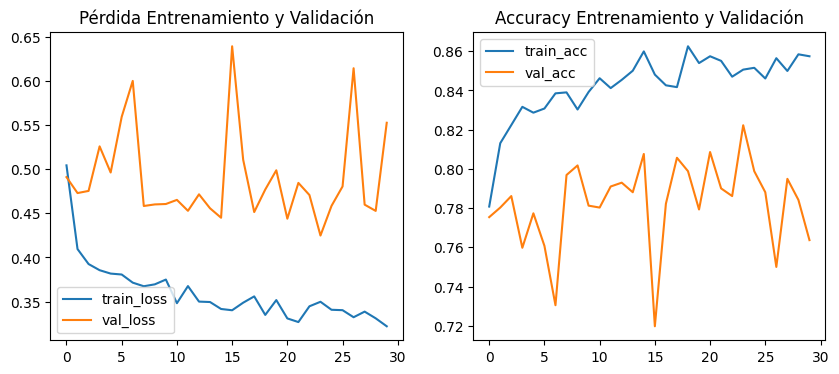

In [182]:
CNN_DA = nn.Sequential(*layers)

CNN_DAc = torch.compile(CNN_DA.to(device))

optimizer_DA = optim.RMSprop(CNN_DAc.parameters(), lr=1e-4)

epochs = 30
historyDA = train_model(CNN_DAc, epochs, train_loader_da, val_loader, criterion, optimizer_DA)
plot_history(historyDA)

Podemos ver que la divergencia entre train y validation más o menos se mantiene, aunque ahora se ve mucho más ruido.

## 5. Usando técnicas de regularización para el modelo

Dado que el data augmentation no ha sido suficiente para paliar el sobreajuste, vamos a introducir dos elementos de regularización: **Dropout** (`Dropout`) y **Batch normalization** (`BatchNorm2d`). Vamos a aprovechar que tenemos que introducir dos nuevas capas por cada bloque, para introducir un nuevo concepto de PyTorch.

### 5.1 Batch Normalization

**Batch Normalization (Normalización por Lotes)**, o **BN**, es una técnica clave para *estabilizar y acelerar* el entrenamiento de redes neuronales profundas. Se aplica típicamente entre una capa de transformación (como Conv2D o Linear) y la función de activación (como ReLU).

El objetivo principal de BN es combatir el *Covariance Shift Interno*, un fenómeno donde la distribución de las entradas de una capa cambia constantemente a medida que se actualizan los pesos de las capas anteriores. Al estabilizar las distribuciones (forzando la media a 0 y la desviación estándar a 1), Batch Normalization:

1.  Permite a las capas posteriores trabajar con entradas más predecibles.
2.  Reduce la necesidad de tasas de aprendizaje muy pequeñas.
3.  Acelera la convergencia del modelo durante el entrenamiento.

BN realiza la transformación en dos pasos:

1.  **Normalización:** Para un batch $B$, se calcula su media ($\mu_B$) y varianza ($\sigma_B^2$). Cada activación ($x_i$) se normaliza usando estas estadísticas.
    $$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

2.  **Escalado y Desplazamiento:** Se introducen dos parámetros *aprendibles* por la red, $\gamma$ (escala) y $\beta$ (desplazamiento), que permiten al modelo restaurar la capacidad de tener representaciones no lineales si es necesario.
    $$y_i = \gamma \hat{x}_i + \beta$$

![](https://www.researchgate.net/publication/354086412/figure/fig2/AS:1060145152917505@1629769709734/sualization-of-batch-normalization-on-a-feature-map-The-mean-and-variance-of-the-values.png)

La capa `BatchNorm2d(num_features=C)` en PyTorch implementa el BN explicado para imágenes, indicando el número de canales $C$ de entrada. Y es que la normalización se realiza para cada canal $C$ de entrada, asumiendo que es un tensor $(N, C, H, W)$ (las estadísticas se calculan para $(N, H, W)$). Por último, es crucial que el comportamiento de BN cambie según la fase:

* **Entrenamiento:** Se utilizan la $\mu$ y $\sigma$ del lote actual. Esto inyecta un ligero ruido que actúa como una forma suave de *regularización*.
* **Prueba/Test:** Se utiliza la *media y varianza acumuladas* (*running mean/variance*), que son estadísticas globales acumuladas durante todo el entrenamiento. Esto garantiza que el resultado sea determinista.

### 5.2 Módulo de modelos
Como aprendimos previamente, las Redes Neuronales Convolucionales a menudo se construyen a partir de una secuencia de bloques o patrones de capas que se repiten (como `Conv` $\to$ `ReLU` $\to$ `MaxPool`). Vamos a aprovechar esta estructura para crear nuestro propio **módulo** personalizado en PyTorch. Luego podremos usar este módulo, que actúa como un contenedor de varias capas, directamente dentro de un modelo nn.Sequential más grande. De hecho, estaremos construyendo lo que a menudo se llama un "modelo dentro de un modelo". Esto se consigue definiendo una clase que herede de `torch.nn.Module`, y al menos dos de sus métodos:

 1. El **Constructor** (`__init__`): se usa para declarar las capas y submódulos que componen nuestro bloque. Define y registra todas las propiedades persistentes del módulo, como las capas convolucionales (nn.Conv2d), las funciones de activación, o incluso otros modelos nn.Sequential anidados.
 2. El **Pase Hacia Adelante** (`forward`): define la lógica de procesamiento de datos del módulo; es decir, cómo se encadenan las capas definidas en `__init__` para transformar el tensor de entrada hasta conseguir la salida.
 
De hecho, utilizar esta estructura de clase `nn.Module` personalizada es la práctica estándar en PyTorch para crear arquitecturas flexibles y reutilizables (por ejemplo, aquellas redes que no sean secuenciales). Es por ello que en las siguientes prácticas la utilizaremos para definir la red por completo.

In [179]:
class BloqueConvolucional(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

    def forward(self, x):
        return self.model(x)

Definimos el modelo usando los bloques convolucionales que hemos definido. Cuando indicamos dropout_p = 0, es lo mismo que no hacer dropout. 

Ahora, podemos permitirnos aumentar un poco el learning rate, ya que usamos batchNormalization. También aumentamos el número de épocas ya que el sobreajuste se mantiene a raya y podemos ir más allá.

Epoch [00/100], Train Loss: 3.6017, Validation Loss: 0.6816, Train Accuracy: 0.5268, Validation Accuracy: 0.5811
Epoch [01/100], Train Loss: 0.7311, Validation Loss: 0.6800, Train Accuracy: 0.5379, Validation Accuracy: 0.5742
Epoch [02/100], Train Loss: 0.6958, Validation Loss: 0.6842, Train Accuracy: 0.5405, Validation Accuracy: 0.5684
Epoch [03/100], Train Loss: 0.6907, Validation Loss: 0.6841, Train Accuracy: 0.5525, Validation Accuracy: 0.5498
Epoch [04/100], Train Loss: 0.6804, Validation Loss: 0.6929, Train Accuracy: 0.5693, Validation Accuracy: 0.5146
Epoch [05/100], Train Loss: 0.6809, Validation Loss: 0.6518, Train Accuracy: 0.5900, Validation Accuracy: 0.5957
Epoch [06/100], Train Loss: 0.6636, Validation Loss: 0.6468, Train Accuracy: 0.5997, Validation Accuracy: 0.6074
Epoch [07/100], Train Loss: 0.6602, Validation Loss: 0.6312, Train Accuracy: 0.6068, Validation Accuracy: 0.6250
Epoch [08/100], Train Loss: 0.6407, Validation Loss: 0.6186, Train Accuracy: 0.6426, Validation 

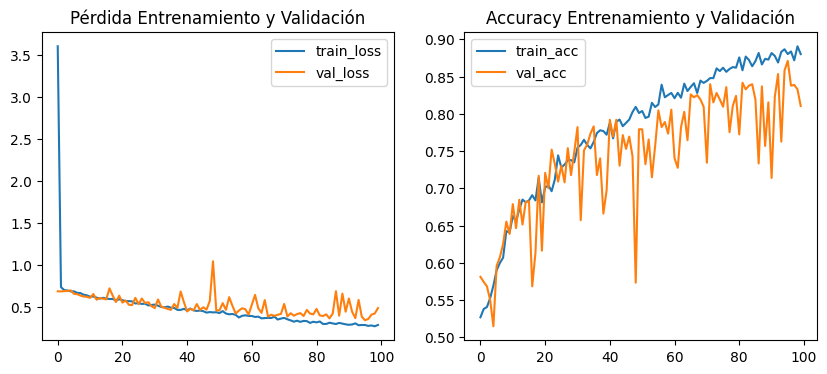

In [183]:
CNN_DADB = nn.Sequential (
    BloqueConvolucional(3, 32,  0),  # Sin dropout
    BloqueConvolucional(32, 64, 0),  # Sin dropout
    BloqueConvolucional(64, 128, 0.2), 
    BloqueConvolucional(128, 128, 0.2), 
    nn.Flatten(),
    nn.Linear(in_features=128 * 7 * 7, out_features=512),
    nn.Dropout(.4),                  # Nuevo dropout
    nn.ReLU(),        
    nn.Linear(in_features=512, out_features=1)
)

CNN_DADBc = torch.compile(CNN_DADB.to(device))

optimizer_DADB = optim.RMSprop(CNN_DADBc.parameters(), lr=1e-3)

epochs = 100  # esto puede tardar un buen rato incluso con una buena GPU, puedes reducir el número de épocas
historyDADB = train_model(CNN_DADBc, epochs, train_loader_da, val_loader, criterion, optimizer_DADB)
plot_history(historyDADB)

Según la información que dan estas gráficas, gracias a la combinación de data augmentation y dropout ya no tenemos sobreajuste. Ambas curvas se mantienen cerca, y ahora alcanzamos una precisión del 82%, lo que supone una mejora considerable respecto del modelo no regularizado.

Ajustando las técnicas de regularización y afinando los parámetros de la red (el número de filtros por capa y el número de capas), podriamos subir quizás hasta un 86-87% de precisión, pero será muy difícil superar este punto entrenando nuestro modelo con tan pocos datos desde cero. Hemos de buscar soluciones alternativas...

In [185]:
evaluate(CNN_DADBc,test_loader,criterion)

(0.525300256209448, 0.7880859375)

Ahora puedes ver cómo de efectivas son las técnicas de regularización, permitiendo por tanto mantener el sobreajuste bajo control y pudiendo así realizar más épocas. 

Cuando hemos tardado tanto en entrenar un buen modelo, es bueno guardarlo para no repetir el proceso. Esto se hace fácilmente con `torch.save`. Lleva cuidado, no podemos guardar modelos compilados, pero sí el modelo original antes de compilar.

*Atención*: Si estás en Google Colab, recuerda descargar el fichero generado o copiarlo a Google Drive.


In [187]:
torch.save(CNN_DADB,'cats_and_dogs_DADB.pth')

## 6. Ejercicios Opcionales Propuestos

1. En el apartado 4, prueba distintas variantes de data augmentation jugando con los parámetros de las transformaciones existentes, y/o añadiendo nuevas. ¿Cómo repercute al entrenamiento?
2. Prueba a realizar el mismo procedimiento de data augmentation + dropout + batchNormalization sobre el dataset [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html), que está disponible desde Torchvision.
